In [1]:
import numpy as np
import pandas as pd
import torch
import nltk
import tensorflow as tf

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

from nltk.sentiment.vader import SentimentIntensityAnalyzer

from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline


c:\Users\drebi\miniconda3\envs\FinBERT\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [48]:
news_df = pd.read_csv('data/news.csv')
stock_df = pd.read_csv('data/price.csv')


In [49]:
stock_df.head()

,Date,ticker,close
0,2017-01-03,A,43.743862
1,2017-01-04,A,44.317825
2,2017-01-05,A,43.790924
3,2017-01-06,A,45.155281
4,2017-01-09,A,45.296406


In [50]:
nltk.download("vader_lexicon")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")
finbert_tokenizer = BertTokenizer.from_pretrained("yiyanghkust/finbert-tone")
finbert = BertForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone")

# nlp = pipeline("sentiment-analysis", model=finbert, tokenizer=tokenizer, max_length=512, truncation=True)


def predict_sentiment(text):
    inputs = finbert_tokenizer(
        text, return_tensors="pt", truncation=True, padding=True, max_length=512
    )
    with torch.no_grad():
        outputs = finbert(**inputs)
    scores = outputs.logits.softmax(dim=1).numpy()[0]
    return scores

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\drebi\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Using device: cuda


In [51]:
# Convert the list of scores into a DataFrame with separate columns
sentiment_df = pd.DataFrame(
    news_df["body"].apply(predict_sentiment).tolist(),
    columns=["neutral", "positive", "negative"],
)

# Append the new columns to news_df
news_df = pd.concat([news_df.reset_index(drop=True), sentiment_df], axis=1)

In [24]:
def VADER_sentiment_score(heading):
    """
    Returns all VADER sentiment scores
    - neg: Negative sentiment (0 to 1)
    - neu: Neutral sentiment (0 to 1)
    - pos: Positive sentiment (0 to 1)
    compound: Normalized aggregate score (-1 to 1)
    """

    analyzer = SentimentIntensityAnalyzer()
    return analyzer.polarity_scores(heading)

In [53]:
VADER_negative = []
VADER_neutral = []
VADER_positive = []
VADER_compound = []


for i in range(len(news_df)):

    headline = news_df.iloc[i]["title"]

    # Analyze headline with VADER
    vader_scores = VADER_sentiment_score(headline)
    VADER_negative.append(vader_scores["neg"])
    VADER_neutral.append(vader_scores["neu"])
    VADER_positive.append(vader_scores["pos"])
    VADER_compound.append(vader_scores["compound"])

    # Optional: Print progress every 100 items
    if i % 100 == 0:
        print(f"Processed {i} items")

    # Get all sentiment scores

# Add all scores to the dataframe
news_df["VADER_negative"] = VADER_negative
news_df["VADER_neutral"] = VADER_neutral
news_df["VADER_positive"] = VADER_positive
news_df["VADER_compound"] = VADER_compound

Processed 0 items
Processed 100 items
Processed 200 items
Processed 300 items
Processed 400 items
Processed 500 items
Processed 600 items
Processed 700 items
Processed 800 items
Processed 900 items
Processed 1000 items
Processed 1100 items
Processed 1200 items
Processed 1300 items
Processed 1400 items
Processed 1500 items
Processed 1600 items
Processed 1700 items
Processed 1800 items
Processed 1900 items
Processed 2000 items
Processed 2100 items
Processed 2200 items
Processed 2300 items
Processed 2400 items
Processed 2500 items
Processed 2600 items
Processed 2700 items
Processed 2800 items
Processed 2900 items
Processed 3000 items
Processed 3100 items
Processed 3200 items
Processed 3300 items
Processed 3400 items
Processed 3500 items
Processed 3600 items
Processed 3700 items
Processed 3800 items
Processed 3900 items
Processed 4000 items
Processed 4100 items
Processed 4200 items
Processed 4300 items
Processed 4400 items
Processed 4500 items
Processed 4600 items
Processed 4700 items
Proc

In [54]:
news_df.head()

,publication_datetime,title,body,tickers,neutral,positive,negative,VADER_negative,VADER_neutral,VADER_positive,VADER_compound
0,2017-01-03,World News: Police Question Netanyahu Over Gifts,"""We pay attention to publications in the media...",EL,0.999937,0.000002,0.000060,0.0,1.000,0.000,0.0000
1,2017-01-03,Business News: Nestle Turns to New CEO for Hea...,"Nestle, the world's largest packaged-food comp...",GIS,0.444897,0.551795,0.003308,0.0,1.000,0.000,0.0000
2,2017-01-03,Business News: Vermont Drug Law Faces Limits -...,"The Vermont law, enacted in June, instructed s...",ABBV,0.999891,0.000026,0.000083,0.0,1.000,0.000,0.0000
3,2017-01-03,Life & Arts -- Travel: How Hotel Companies Lau...,Travelers are about to see a flurry of new hot...,HLT,0.999991,0.000006,0.000003,0.0,1.000,0.000,0.0000
4,2017-01-03,Businesses Ready to Ramp Up Investment --- Aft...,The Federal Reserve last month signaled intere...,HD,0.984549,0.013953,0.001498,0.0,0.894,0.106,0.3612


In [18]:
news_df.to_csv('data/news_w_sentiment.csv', index=False)

In [2]:
# loading stock price and news data
stock_data = pd.read_csv("data/price.csv")
news_data = pd.read_csv("data/news_w_sentiment.csv")

news_data['FinBERT score'] = news_data['positive'] - news_data['negative']

stock_column = ['close']
news_column = ['FinBERT score']


In [3]:
def calculate_r2(y_true, y_pred, in_sample=True, benchmark=None):
    if in_sample:
        return 1 - (
            np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)
        )
    else:
        if benchmark is None:
            raise ValueError(
                "Benchmark must be provided for out-of-sample R-squared calculation."
            )
        return 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - benchmark) ** 2))

In [4]:
# hyperparameters
split = (0.85);
sequence_length = 10;
epochs = 10
learning_rate = 0.01

# loading stock price data
stock_data = pd.read_csv("data/price.csv")
column = ['close']


len_stock_data = stock_data.shape[0]


# splitting data to train and test
train_examples = int(len_stock_data * split)
train = stock_data.get(column).values[:train_examples]
test = stock_data.get(column).values[train_examples:]
len_train = train.shape[0]
len_test = test.shape[0]


# normalizing data
scaler = MinMaxScaler()
train, test = scaler.fit_transform(train), scaler.fit_transform(test)


# splitting training data to x and y
X_train = []
for i in range(len_train - sequence_length):
    X_train.append(train[i : i + sequence_length])
X_train = np.array(X_train).astype(float)
y_train = np.array(train[sequence_length:]).astype(float)

# splitting testing data to x and y
X_test = []
for i in range(len_test - sequence_length):
    X_test.append(test[i : i + sequence_length])
X_test = np.array(X_test).astype(float)
y_test = np.array(test[sequence_length:]).astype(float)


# MLP Model
def model_create():
    tf.random.set_seed(1234)
    model = tf.keras.models.Sequential(
        [
            tf.keras.Input(shape=(X_train.shape[1], 1)),
            tf.keras.layers.LSTM(units=50, activation="tanh", return_sequences=True),
            tf.keras.layers.Dropout(0.15),
            tf.keras.layers.LSTM(units=30, activation="tanh", return_sequences=True),
            tf.keras.layers.Dropout(0.05),
            tf.keras.layers.LSTM(units=20, activation="tanh", return_sequences=False),
            tf.keras.layers.Dropout(0.01),
            tf.keras.layers.Dense(units=1, activation="linear"),
        ]
    )

    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    )

    # Fit the model and store the history
    history = model.fit(
        X_train,
        y_train,
        epochs=epochs,
        validation_split=0.2,
        verbose=1
    )
    return model, history


# inverting normaliztion
y_test = scaler.inverse_transform(y_test)


# prediction on test set
def predict(model):
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).reshape(-1, 1)
    return predictions


# evaluation
def evaluate(predictions):
    mae = mean_absolute_error(predictions, y_test)
    mape = mean_absolute_percentage_error(predictions, y_test)
    r2 = calculate_r2(y_test, predictions, in_sample=False, benchmark = 0)
    return mae, mape, (1 - mape), r2


def run_model(n):

    total_mae = total_mape = total_acc =total_r2 = 0
    histories = []

    for i in range(n):
        model, history = model_create()
        predictions = predict(model)
        mae, mape, acc, r2 = evaluate(predictions)
        total_mae += mae
        total_mape += mape
        total_acc += acc
        total_r2 += r2
        histories.append(history)

    return (total_mae / n), (total_mape / n), (total_acc / n), histories, predictions.tolist(), (total_r2/n)

mae, mape, acc, preds, histories, r2 = run_model(1)


print(f"Mean Absolute Error = {mae}")
print(f"Mean Absolute Percentage Error = {mape}%")
print(f"Accuracy = {acc}")
print(f"R2 Score = {r2}")

Epoch 1/10
12832/12832 ━━━━━━━━━━━━━━━━━━━━ 81s 6ms/step - loss: 5.5188e-05 - val_loss: 6.4721e-04
Epoch 2/10
12832/12832 ━━━━━━━━━━━━━━━━━━━━ 75s 6ms/step - loss: 9.7579e-06 - val_loss: 6.1479e-04
Epoch 3/10
12832/12832 ━━━━━━━━━━━━━━━━━━━━ 79s 6ms/step - loss: 7.4869e-06 - val_loss: 1.7868e-04
Epoch 4/10
12832/12832 ━━━━━━━━━━━━━━━━━━━━ 79s 6ms/step - loss: 6.8463e-06 - val_loss: 7.6934e-05
Epoch 5/10
12832/12832 ━━━━━━━━━━━━━━━━━━━━ 83s 6ms/step - loss: 6.4706e-06 - val_loss: 1.2131e-04
Epoch 6/10
12832/12832 ━━━━━━━━━━━━━━━━━━━━ 81s 6ms/step - loss: 6.1716e-06 - val_loss: 1.1593e-04
Epoch 7/10
12832/12832 ━━━━━━━━━━━━━━━━━━━━ 83s 6ms/step - loss: 5.9697e-06 - val_loss: 8.8320e-05
Epoch 8/10
12832/12832 ━━━━━━━━━━━━━━━━━━━━ 82s 6ms/step - loss: 5.4789e-06 - val_loss: 1.1716e-04
Epoch 9/10
12832/12832 ━━━━━━━━━━━━━━━━━━━━ 83s 6ms/step - loss: 5.5366e-06 - val_loss: 1.4981e-04
Epoch 10/10
12832/12832 ━━━━━━━━━━━━━━━━━━━━ 86s 7ms/step - loss: 5.2495e-06 - val_loss: 3.7766e-04
2831/2831

Epoch 1/10
12832/12832 ━━━━━━━━━━━━━━━━━━━━ 82s 6ms/step - loss: 9.4966e-05 - val_loss: 3.3825e-04
Epoch 2/10
12832/12832 ━━━━━━━━━━━━━━━━━━━━ 87s 7ms/step - loss: 1.5324e-05 - val_loss: 6.2005e-04
Epoch 3/10
12832/12832 ━━━━━━━━━━━━━━━━━━━━ 83s 6ms/step - loss: 1.2468e-05 - val_loss: 6.0748e-04
Epoch 4/10
12832/12832 ━━━━━━━━━━━━━━━━━━━━ 86s 7ms/step - loss: 1.0705e-05 - val_loss: 2.1585e-04
Epoch 5/10
12832/12832 ━━━━━━━━━━━━━━━━━━━━ 86s 7ms/step - loss: 9.8338e-06 - val_loss: 0.0010
Epoch 6/10
12832/12832 ━━━━━━━━━━━━━━━━━━━━ 85s 7ms/step - loss: 8.2411e-06 - val_loss: 1.2428e-04
Epoch 7/10
12832/12832 ━━━━━━━━━━━━━━━━━━━━ 86s 7ms/step - loss: 9.8156e-06 - val_loss: 7.0967e-04
Epoch 8/10
12832/12832 ━━━━━━━━━━━━━━━━━━━━ 89s 7ms/step - loss: 8.1511e-06 - val_loss: 7.9542e-05
Epoch 9/10
12832/12832 ━━━━━━━━━━━━━━━━━━━━ 89s 7ms/step - loss: 2.5073e-05 - val_loss: 0.0011
Epoch 10/10
12832/12832 ━━━━━━━━━━━━━━━━━━━━ 90s 7ms/step - loss: 6.8754e-05 - val_loss: 0.0015
2831/2831 ━━━━━━━━━━━

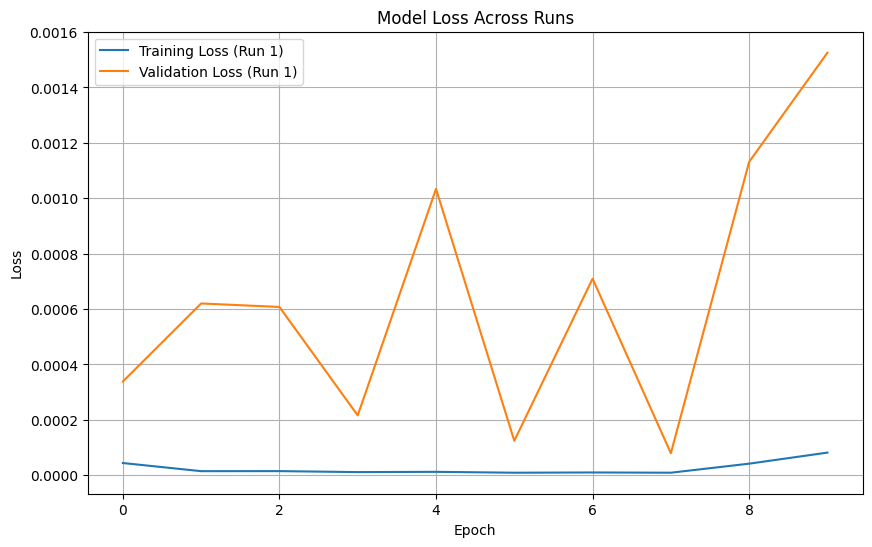

In [5]:
stock_data = pd.read_csv("data/price.csv")
column = ['close']

# hyperparameters
split = (0.85);
sequence_length = 10;
epochs = 10
learning_rate = 0.02
validation_split = 0.2  # 20% of training data for validation

len_stock_data = stock_data.shape[0]

# splitting data to train and test
train_examples = int(len_stock_data * split)
train = stock_data.get(column).values[:train_examples]
test = stock_data.get(column).values[train_examples:]
len_train = train.shape[0]
len_test = test.shape[0]

# normalizing data
scaler = MinMaxScaler()
train, test = scaler.fit_transform(train), scaler.fit_transform(test)

# splitting training data to x and y
X_train = []
for i in range(len_train - sequence_length):
    X_train.append(train[i : i + sequence_length])
X_train = np.array(X_train).astype(float)
y_train = np.array(train[sequence_length:]).astype(float)

# splitting testing data to x and y
X_test = []
for i in range(len_test - sequence_length):
    X_test.append(test[i : i + sequence_length])
X_test = np.array(X_test).astype(float)
y_test = np.array(test[sequence_length:]).astype(float)


#creating LSTM model
def model_create():
    tf.random.set_seed(1234)
    model = tf.keras.models.Sequential(
        [
            tf.keras.Input(shape = (X_train.shape[1], 1)),
            tf.keras.layers.LSTM(units = 50, activation = "tanh", return_sequences = True),
            tf.keras.layers.Dropout(0.15),
            tf.keras.layers.LSTM(units = 30, activation = "tanh", return_sequences = True),
            tf.keras.layers.Dropout(0.05),
            tf.keras.layers.LSTM(units = 20, activation = "tanh", return_sequences = False),
            tf.keras.layers.Dropout(0.01),
            tf.keras.layers.Dense(units = 1, activation = "linear")
        ]
    )

    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    )

    # Train the model with validation split
    history = model.fit(
        X_train, y_train,
        epochs = epochs,
        validation_split = validation_split,
        verbose = 1
    )
    
    return model, history

# inverting normaliztion
y_test = scaler.inverse_transform(y_test)



# prediction on test set
def predict(model):
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions.reshape(-1,1)).reshape(-1,1)
    return predictions


# evaluation
def evaluate(predictions):
    mae = mean_absolute_error(predictions, y_test)
    mape = mean_absolute_percentage_error(predictions, y_test)
    r2 = calculate_r2(y_test, predictions, in_sample=False, benchmark=0)
    return mae, mape, (1 - mape), r2


# trial runs
def run_model(n):
    total_mae = total_mape = total_acc = total_r2 = 0
    histories = []
    for i in range(n):
        model, history = model_create()
        predictions = predict(model)
        mae, mape, acc, r2 = evaluate(predictions)
        total_mae += mae
        total_mape += mape 
        total_acc += acc
        total_r2 += r2
        histories.append(history)
    return (total_mae / n), (total_mape / n), (total_acc / n), predictions.tolist(), (total_r2 / n), histories

mae, mape, acc, preds, r2, histories = run_model(1)

print(f"Mean Absolute Error = {mae}")
print(f"Mean Absolute Percentage Error = {mape}%")
print(f"Accuracy = {acc}")
print(f"R-squared = {r2}")


plt.figure(figsize=(10, 6))
for i, history in enumerate(histories):
    plt.plot(history.history['loss'], label=f'Training Loss (Run {i+1})')
    plt.plot(history.history['val_loss'], label=f'Validation Loss (Run {i+1})')
plt.title('Model Loss Across Runs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Epoch 1/10
12832/12832 ━━━━━━━━━━━━━━━━━━━━ 73s 6ms/step - loss: 1.0481e-04 - val_loss: 5.1135e-04
Epoch 2/10
12832/12832 ━━━━━━━━━━━━━━━━━━━━ 72s 6ms/step - loss: 8.7082e-06 - val_loss: 3.9360e-04
Epoch 3/10
12832/12832 ━━━━━━━━━━━━━━━━━━━━ 74s 6ms/step - loss: 6.7004e-06 - val_loss: 1.8102e-04
Epoch 4/10
12832/12832 ━━━━━━━━━━━━━━━━━━━━ 72s 6ms/step - loss: 6.6398e-06 - val_loss: 3.3098e-04
Epoch 5/10
12832/12832 ━━━━━━━━━━━━━━━━━━━━ 74s 6ms/step - loss: 5.6465e-06 - val_loss: 4.9416e-04
Epoch 6/10
12832/12832 ━━━━━━━━━━━━━━━━━━━━ 81s 6ms/step - loss: 5.2854e-06 - val_loss: 4.4671e-04
Epoch 7/10
12832/12832 ━━━━━━━━━━━━━━━━━━━━ 73s 6ms/step - loss: 4.8940e-06 - val_loss: 5.3880e-04
Epoch 8/10
12832/12832 ━━━━━━━━━━━━━━━━━━━━ 80s 6ms/step - loss: 4.6405e-06 - val_loss: 6.0116e-04
Epoch 9/10
12832/12832 ━━━━━━━━━━━━━━━━━━━━ 71s 6ms/step - loss: 4.7583e-06 - val_loss: 5.4938e-04
Epoch 10/10
12832/12832 ━━━━━━━━━━━━━━━━━━━━ 75s 6ms/step - loss: 4.4351e-06 - val_loss: 5.2947e-04
2831/2831

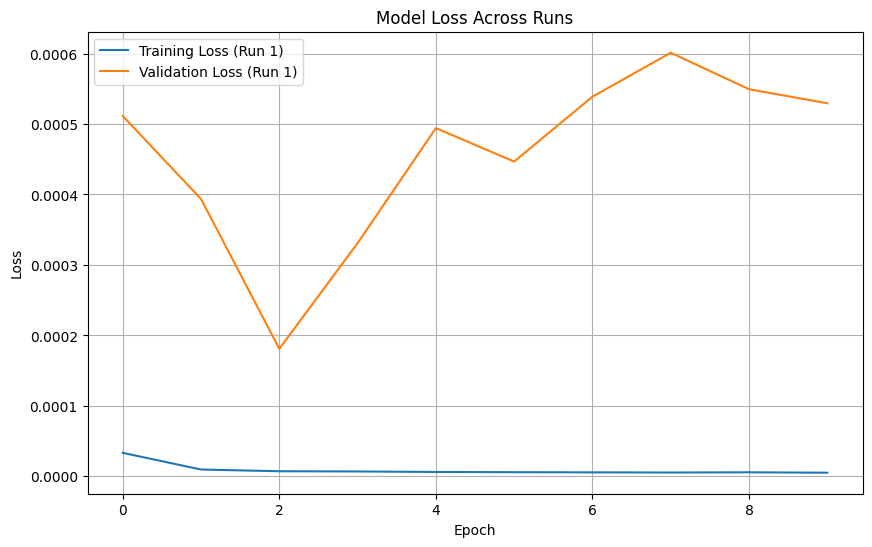

In [3]:

# hyperparameters
split = (0.85);
sequence_length = 10;
epochs = 10
learning_rate = 0.02



# loading stock price and news data
stock_data = pd.read_csv("data/price.csv")
news_data = pd.read_csv("data/news_w_sentiment.csv")

news_data['FinBERT score'] = news_data['positive'] - news_data['negative']

stock_column = ['close']
news_column = ['FinBERT score']

len_stock_data = stock_data.shape[0]

# splitting data to train and test
train_examples = int(len_stock_data * split)
train = stock_data.get(stock_column).values[:train_examples]
train_sentiment = news_data.get(news_column).values[:train_examples]
test = stock_data.get(stock_column).values[train_examples:]
test_sentiment = news_data.get(news_column).values[train_examples:]
len_train = train.shape[0]
len_test = test.shape[0]
len_train_sentiment = train_sentiment.shape[0]
len_test_sentiment = test_sentiment.shape[0]


# normalizing data
scaler = MinMaxScaler()
train, test = scaler.fit_transform(train), scaler.fit_transform(test)


# splitting training data to x and y
X_train = []
for i in range(len_train - sequence_length):
    X_train.append(train[i : i + sequence_length])
len_X_train = len(X_train)
y_train = np.array(train[sequence_length:]).astype(float)


# splitting testing data to x and y
X_test = []
for i in range(len_test - sequence_length):
    X_test.append(test[i : i + sequence_length])
len_X_test = len(X_test)
y_test = np.array(test[sequence_length:]).astype(float)


# adding news sentiment to train and test
for i in range(len_X_train):
    X_train[i] = X_train[i].tolist()
    # Check if we have sentiment data
    if len_train_sentiment > 0:
        if i + sequence_length < len_train_sentiment:
            X_train[i].append(train_sentiment[i + sequence_length].tolist())
        else:
            # If we're at the end, use the last available sentiment
            X_train[i].append(train_sentiment[-1].tolist())
    else:
        # If no sentiment data, append 0
        X_train[i].append([0.0])
X_train = np.array(X_train).astype(float)

for i in range(len_X_test):
    X_test[i] = X_test[i].tolist()
    # Check if we have sentiment data
    if len_test_sentiment > 0:
        if i + sequence_length < len_test_sentiment:
            X_test[i].append(test_sentiment[i + sequence_length].tolist())
        else:
            # If we're at the end, use the last available sentiment
            X_test[i].append(test_sentiment[-1].tolist())
    else:
        # If no sentiment data, append 0
        X_test[i].append([0.0])
X_test = np.array(X_test).astype(float)

def calculate_r2(y_true, y_pred, in_sample=True, benchmark=None):
    if in_sample:
        return 1 - (np.sum((y_true - y_pred) ** 2) / 
                    np.sum((y_true - np.mean(y_true)) ** 2))
    else:
        if benchmark is None:
            raise ValueError("Benchmark must be provided for out-of-sample R-squared calculation.")
        return 1 - (np.sum((y_true - y_pred) ** 2) / 
                    np.sum((y_true - benchmark) ** 2))

#%%
#creating LSTM model
def model_create():
    tf.random.set_seed(1234)
    model = tf.keras.models.Sequential(
        [
            tf.keras.Input(shape = (X_train.shape[1], 1)),
            tf.keras.layers.LSTM(units = 70, activation = "tanh", return_sequences = True),
            tf.keras.layers.LSTM(units = 30, activation = "tanh", return_sequences = True),
            tf.keras.layers.LSTM(units = 10, activation = "tanh", return_sequences = False),
            tf.keras.layers.Dense(units = 1, activation = "linear")
        ]
    )

    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    )

    # Split training data into training and validation sets (80-20 split)
    val_split = 0.2
    val_size = int(len(X_train) * val_split)
    
    X_val = X_train[-val_size:]
    y_val = y_train[-val_size:]
    X_train_new = X_train[:-val_size]
    y_train_new = y_train[:-val_size]

    # Train the model with validation data
    history = model.fit(
        X_train_new, y_train_new,
        validation_data=(X_val, y_val),
        epochs = epochs,
        verbose=1
    )
    
    return model, history

#%%

# inverting normaliztion
y_test = scaler.inverse_transform(y_test)



# prediction on test set
def predict(model):
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions.reshape(-1,1)).reshape(-1,1)
    return predictions



# evaluation
def evaluate(predictions):
    mae = mean_absolute_error(predictions, y_test)
    mape = mean_absolute_percentage_error(predictions, y_test)
    r2 = calculate_r2(y_test, predictions, in_sample=False, benchmark=0)
    return mae, mape, (1 - mape), r2


# trial runs
def run_model(n):
    total_mae = total_mape = total_acc= total_r2 = 0
    histories = []
    for i in range(n):
        model, history = model_create()  # Modified to receive history
        predictions = predict(model)
        mae, mape, acc, r2 = evaluate(predictions)
        total_mae += mae
        total_mape += mape 
        total_acc += acc
        total_r2 += r2
        histories.append(history)
    return (total_mae / n), (total_mape / n), (total_acc / n), (total_r2 / n), histories

#%%
# Run the model and get the histories
mae, mape, acc, r2, histories = run_model(1)

print(f"Mean Absolute Error = {mae}")
print(f"Mean Absolute Percentage Error = {mape}%")
print(f"Accuracy = {acc}")
print(f"R-squared = {r2}")

# Plot the final training and validation loss
plt.figure(figsize=(10, 6))
for i, history in enumerate(histories):
    plt.plot(history.history['loss'], label=f'Training Loss (Run {i+1})')
    plt.plot(history.history['val_loss'], label=f'Validation Loss (Run {i+1})')
plt.title('Model Loss Across Runs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
# %%
